# MROOM Hackathon: Some tips and tricks to get started

TU-E5030 - Creating Value with Analytics D, Week 6

*Jukka Luoma, Aalto University*

Version 1.0
Last updated: February 7, 2024

---

*Please note that the analyses presented here are intended to help you get started, not to indicate what is the 'correct' solution to the hackathon.*

---

## Overview

This notebook performs some basic cleaning operations for the data and demostrates a number of data wrangling tricks that allows gleaning insights from the data. By running this notebook you get certain metrics added to your datasets that may be useful to you in your solution development process. These include:

- _Wait times_: How long the customer waited in the queue before getting service. Both realized and expected wait times are provided.
- _Service time_: How long the customer service process takes.
- _Service interval_: What is the time distance between the previous service and current service.
- _Product purchase conversion and value_: How often and how much the customer buy various products when visiting a store to get service.

The notebook also demonstrates how the data can be aggregated at different levels for subsequent analysis. Please note that you may want to aggregate the data in a different way. Some example visualizations and analyses are also shown, to show _how_ you could analyze the data. Please do not take them as indications of _what_ you should be looking for in the data.

*Please make sure that the analyses and assumptions are suitable for your solution and do not just blindly build on this notebook. Although the notebook has been reviewed for mistakes, errors are possible.*

In [2]:
# Preliminary step
# Optional: set this as the location of your data files on Jupyter Hub
# (if not in the same directory as this notebook)
import os
os.chdir("/coursedata/hackathon")
print(os.getcwd())

/coursedata/hackathon


In [3]:
# Read the data

import pandas as pd
# Pandas has some trouble interpreting what is going on in column 25
# Tell pandas it's a string (it's a date field, but we'll get to it later)
df=pd.read_csv('hackathon_data.csv', dtype={25:str})

In [4]:
# A function to combine similar similar membership types into one
# You can modify this to match your needs
# Can be used for other columns as well

import numpy as np

def tier_consolidation(df: pd.DataFrame):

    conditions = [
        df['membership_type'].str.contains("platinum", case = False),
        df['membership_type'].str.contains("gold", case = False),
        df['membership_type'].str.contains("silver", case = False),
        df['membership_type'].str.contains("white", case = False),
        df['membership_type'].str.contains("none", case = False),
    ]

    membership_condensated = [
        "platinum",
        "gold",
        "silver",
        "white",
        "none"
    ]

    df['membership_condensated'] = np.select(conditions, membership_condensated, default="nonmember")  
   
    return df

In [5]:
# Consolidate membership tier data
# Print some things to check it works OK

df = tier_consolidation(df)
df[['membership_type','membership_condensated']]
print("Checking the consolidation")
print(df.groupby(['membership_type','membership_condensated']).size())
print("Membership-tier distribution")
print(df.groupby(['membership_condensated']).size()/len(df))
print("Members")
df['is_member'] = np.where(df['membership_condensated'] == 'nonmember', False, True)
print(df.groupby("is_member").size())

Checking the consolidation
membership_type                membership_condensated
Cyber Monday Silver -23        silver                        65
Ei voimassa olevaa jäsenyyttä  nonmember                 771491
GOLD                           gold                           1
Gold                           gold                       24696
Gold 15                        gold                        1505
Gold 18                        gold                         144
Gold 20                        gold                        8121
Platinum                       platinum                    3008
Platinum 25                    platinum                     772
Silver                         silver                    200025
Silver 10                      silver                     14934
Silver 10 BF                   silver                     15712
Silver 10 Daytime              silver                      3704
White                          white                         48
dtype: int64
Membership

In [6]:
# Process columns that contain dates

date_columns = ['receipt_created','added','serviced','finished','wait_estimate']
for column in date_columns:
    # Some zeros in the data. Replace with np.nan to ignore them in subsequent analyses
    df[column] = df[column].replace("0",np.nan) 
    df[column] = pd.to_datetime(df[column], format='%d.%m.%Y %H.%M.%S')
df[['receipt_created','added','serviced','finished','wait_estimate']].describe()

,receipt_created,added,serviced,finished,wait_estimate
count,1044226,994534,994532,994534,860214
mean,2023-01-07 00:05:51.240631296,2023-01-10 00:09:23.247459072,2023-01-10 00:38:53.529728,2023-01-10 01:21:36.108141824,2023-02-22 03:30:33.906563072
min,2022-01-01 08:42:58,2022-01-02 12:00:27,2022-01-02 12:00:29,2022-01-02 12:29:54,2022-03-24 14:53:00
25%,2022-07-09 12:29:27,2022-07-14 17:20:58,2022-07-14 17:49:57.249999872,2022-07-14 18:21:26.249999872,2022-09-14 15:54:30
50%,2023-01-07 12:46:42,2023-01-13 10:26:09.500000,2023-01-13 10:51:11.500000,2023-01-13 11:26:40.500000,2023-02-26 15:39:30
75%,2023-07-07 09:24:06.500000,2023-07-08 09:44:08,2023-07-08 10:09:05,2023-07-08 10:46:29,2023-07-29 10:34:00
max,2023-12-31 17:38:55,2023-12-31 15:58:46,2023-12-31 17:03:25,2024-01-06 13:09:17,2023-12-31 17:18:00


In [7]:
# Investigate data types

df.dtypes

receipt_row_id                     int64
employee_id                        int64
price                            float64
amount                             int64
vat                              float64
discount                           int64
row_type                          object
campaign_id                      float64
campaign_discount                float64
receipt_id                         int64
receipt_created           datetime64[ns]
customer_id                      float64
membership_id                    float64
membership_type                   object
product_id                       float64
product_name                      object
product_price                    float64
pob_id                             int64
row_total                        float64
hour                               int64
product_category                  object
queue_id                         float64
added                     datetime64[ns]
serviced                  datetime64[ns]
finished        

In [8]:
df_copy=df.copy()

In [9]:
# Aggregate by receipt number
# Please note that for some analyses you may NOT want to perform this aggregation
dummies = pd.get_dummies(df_copy['product_category'], prefix="product_category", dtype=int, drop_first=False)
df_copy=pd.concat([df_copy,dummies],axis=1)
df_copy['row_value'] = df_copy['price']*df_copy['amount']
df_copy['row_value_product'] = df_copy['price']*df_copy['amount']*(df_copy['product_category_Product']>0)
df_receipt = df_copy.groupby('receipt_id').agg(
    {'receipt_row_id': 'count', # Note that after aggregation this actually captures just the number of rows that were aggregated
     'row_value': 'sum', # Total value of the receipt
     'row_value_product': 'sum', # Total value of the receipt from product sales
     'customer_id':'last',
     'product_category_Membership': 'sum',
     'product_category_Other': 'sum',
     'product_category_Product': 'sum',
     'product_category_Service': 'sum',
     'membership_condensated': 'last',
     'membership_id': 'last',
     'receipt_created': 'last',
     'added':'last',
     'serviced':'last',
     'finished':'last',
     'wait_estimate':'last',
     'product_name': list,
     'pob_id': 'last',
     }).reset_index()

# Examine the data
df_receipt.head()

,receipt_id,receipt_row_id,row_value,row_value_product,customer_id,product_category_Membership,product_category_Other,product_category_Product,product_category_Service,membership_condensated,membership_id,receipt_created,added,serviced,finished,wait_estimate,product_name,pob_id
0,4653670,1,33.0,0.0,NaN,0,0,0,1,nonmember,NaN,2022-01-02 12:30:04,2022-01-02 12:00:27,2022-01-02 12:00:29,2022-01-02 12:29:54,NaT,[M Cut™],27
1,4653671,1,33.0,0.0,NaN,0,0,0,1,nonmember,NaN,2022-01-02 12:44:08,2022-01-02 12:22:26,2022-01-02 12:22:28,2022-01-02 12:43:54,NaT,[M Cut™],27
2,4653672,1,33.0,0.0,NaN,0,0,0,1,nonmember,NaN,2022-01-02 12:53:58,2022-01-02 12:23:44,2022-01-02 12:31:25,2022-01-02 12:53:51,NaT,[M Cut™],27
3,4653673,1,33.0,0.0,747701.0,0,0,0,1,nonmember,NaN,2022-01-02 13:38:05,2022-01-02 13:10:08,2022-01-02 13:10:10,2022-01-02 13:37:49,NaT,[M Cut™],27
4,4653674,1,33.0,0.0,755200.0,0,0,0,1,nonmember,NaN,2022-01-02 13:40:03,2022-01-02 13:23:49,2022-01-02 13:23:52,2022-01-02 13:40:00,NaT,[M Cut™],27


In [10]:
print(df.columns)

Index(['receipt_row_id', 'employee_id', 'price', 'amount', 'vat', 'discount',
       'row_type', 'campaign_id', 'campaign_discount', 'receipt_id',
       'receipt_created', 'customer_id', 'membership_id', 'membership_type',
       'product_id', 'product_name', 'product_price', 'pob_id', 'row_total',
       'hour', 'product_category', 'queue_id', 'added', 'serviced', 'finished',
       'wait_estimate', 'membership_condensated', 'is_member'],
      dtype='object')


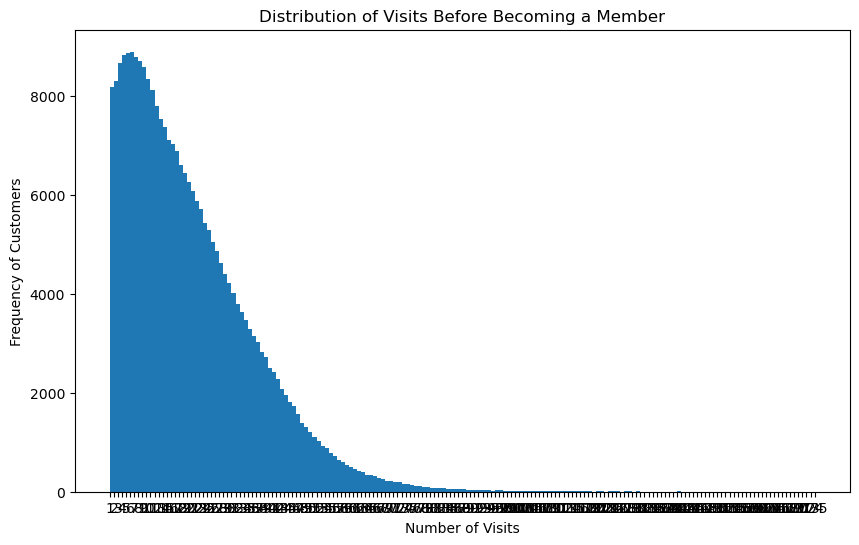

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame
# Convert 'receipt_created' to datetime if it's not already
df['receipt_created'] = pd.to_datetime(df['receipt_created'])

# Filter the DataFrame for rows where customers either remained nonmembers or became members
df_filtered = df[(df['membership_condensated'] == 'nonmember') | df['membership_id'].notna()]

# Sort by customer_id and receipt_created to ensure the order of visits is correct
df_filtered = df_filtered.sort_values(by=['customer_id', 'receipt_created'])

# Calculate the visit number for each customer
df_filtered['visit_number'] = df_filtered.groupby('customer_id').cumcount() + 1

# Identify the visit where each customer became a member
membership_visits = df_filtered[df_filtered['membership_id'].notna()]

# Plot the distribution of visits before becoming a member
plt.figure(figsize=(10, 6))
membership_visits['visit_number'].hist(bins=range(1, int(membership_visits['visit_number'].max()) + 1))
plt.title('Distribution of Visits Before Becoming a Member')
plt.xlabel('Number of Visits')
plt.ylabel('Frequency of Customers')
plt.xticks(range(1, int(membership_visits['visit_number'].max()) + 1))
plt.grid(False)
plt.show()


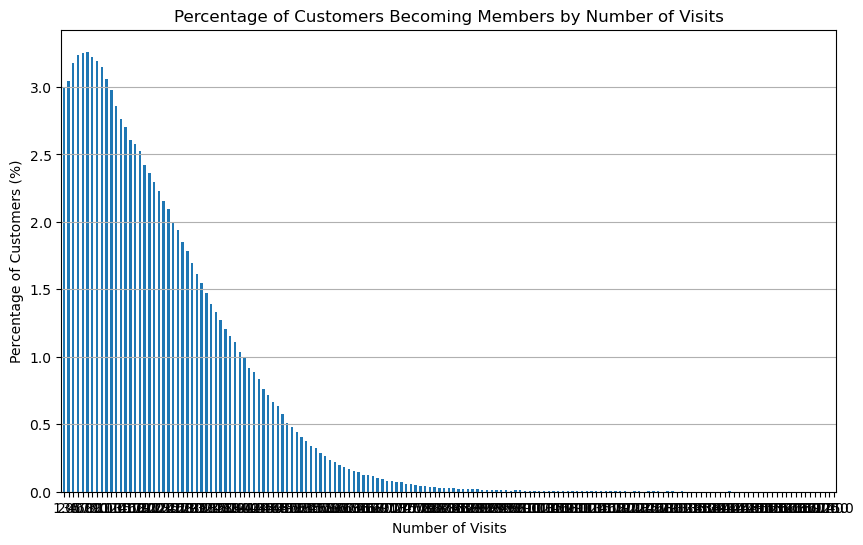

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame
# Convert 'receipt_created' to datetime if it's not already
df['receipt_created'] = pd.to_datetime(df['receipt_created'])

# Filter the DataFrame for rows where customers either remained nonmembers or became members
df_filtered = df[(df['membership_condensated'] == 'nonmember') | df['membership_id'].notna()]

# Sort by customer_id and receipt_created to ensure the order of visits is correct
df_filtered = df_filtered.sort_values(by=['customer_id', 'receipt_created'])

# Calculate the visit number for each customer
df_filtered['visit_number'] = df_filtered.groupby('customer_id').cumcount() + 1

# Identify the visit where each customer became a member
membership_visits = df_filtered[df_filtered['membership_id'].notna()]

# Calculate the percentage of customers for each number of visits before becoming a member
counts = membership_visits['visit_number'].value_counts(normalize=True) * 100
counts.sort_index(inplace=True)

# Plot the distribution as a percentage
plt.figure(figsize=(10, 6))
counts.plot(kind='bar')
plt.title('Percentage of Customers Becoming Members by Number of Visits')
plt.xlabel('Number of Visits')
plt.ylabel('Percentage of Customers (%)')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()


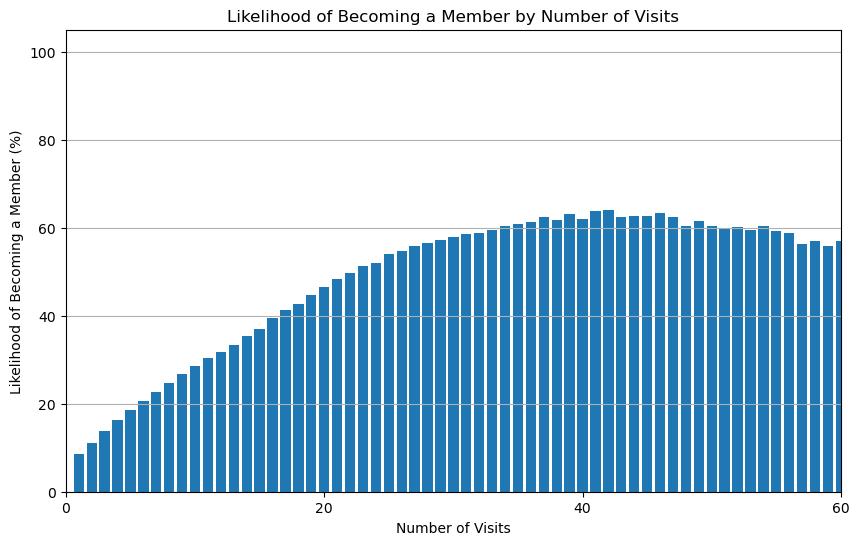

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and already loaded
df['receipt_created'] = pd.to_datetime(df['receipt_created'])
df_filtered = df.sort_values(by=['customer_id', 'receipt_created'])

# Flag the rows where membership is acquired
df_filtered['is_new_member'] = df_filtered['membership_id'].notna()

# Determine the visit number for each customer
df_filtered['visit_number'] = df_filtered.groupby('customer_id').cumcount() + 1

# For each visit number, count the total number of visits and the number of new memberships
visit_stats = df_filtered.groupby('visit_number').agg(
    total_visits=pd.NamedAgg(column="visit_number", aggfunc="count"),
    new_memberships=pd.NamedAgg(column="is_new_member", aggfunc="sum")
).reset_index()

# Calculate the likelihood of becoming a member after each number of visits
visit_stats['likelihood'] = (visit_stats['new_memberships'] / visit_stats['total_visits']) * 100

# Plot the likelihood
plt.figure(figsize=(10, 6))
plt.bar(visit_stats['visit_number'], visit_stats['likelihood'])
plt.title('Likelihood of Becoming a Member by Number of Visits')
plt.xlabel('Number of Visits')
plt.ylabel('Likelihood of Becoming a Member (%)')
tick_interval = max(1, len(visit_stats) // 10)  # Adjust this value as needed for optimal spacing
plt.xlim(0, 60)
plt.xticks(range(0, 61, tick_interval))
plt.grid(axis='y')
plt.show()


In [14]:
import pandas as pd

# Assuming 'df' is your DataFrame and already loaded
df['receipt_created'] = pd.to_datetime(df['receipt_created'])
df = df.sort_values(by=['customer_id', 'receipt_created'])

# Step 1: Identify first visits and check membership status
first_visits = df.drop_duplicates(subset='customer_id', keep='first')
non_members_at_first_visit = first_visits[first_visits['membership_id'].isna()]['customer_id'].unique()

# Step 2: Identify customers who become members in subsequent visits
# Filter for visits only by those who were non-members at their first visit
subsequent_visits = df[df['customer_id'].isin(non_members_at_first_visit)]

# Among these, find unique customer_ids who acquire a membership in later visits
becomes_members_later = subsequent_visits[subsequent_visits['membership_id'].notna()]['customer_id'].unique()

# Create a new column 'becomes_member_later' and set to False initially
df['becomes_member_later'] = False

# Update the 'becomes_member_later' for customers who become members after their first visit
df.loc[df['customer_id'].isin(becomes_members_later), 'becomes_member_later'] = True

df['waiting_time_minutes'] = (df['serviced'] - df['added']).dt.total_seconds() / 60

# Now, 'df' contains a new column 'becomes_member_later' indicating whether a customer becomes a member after their first visit
df.head()


,receipt_row_id,employee_id,price,amount,vat,discount,row_type,campaign_id,campaign_discount,receipt_id,...,product_category,queue_id,added,serviced,finished,wait_estimate,membership_condensated,is_member,becomes_member_later,waiting_time_minutes
110669,5907482,2,23.0,1,24.0,0,NaN,NaN,NaN,4734914,...,Service,NaN,NaT,NaT,NaT,NaT,nonmember,False,False,NaN
147298,5948335,2,23.0,1,24.0,0,NaN,NaN,NaN,4765783,...,Service,NaN,NaT,NaT,NaT,NaT,nonmember,False,False,NaN
10945,5805157,876339,33.0,1,24.0,0,NaN,NaN,NaN,4661931,...,Service,3495325.0,2022-01-13 11:11:43,2022-01-13 11:14:03,2022-01-13 11:36:20,NaT,nonmember,False,True,2.333333
46591,5841705,843754,33.0,1,24.0,0,NaN,NaN,NaN,4687656,...,Service,3522210.0,2022-02-10 11:49:42,2022-02-10 12:22:42,2022-02-10 12:41:18,NaT,nonmember,False,True,33.000000
46594,5841708,843754,12.5,1,24.0,0,NaN,NaN,NaN,4687656,...,Product,3522210.0,2022-02-10 11:49:42,2022-02-10 12:22:42,2022-02-10 12:41:18,NaT,nonmember,False,True,33.000000


In [15]:
# Assuming df is your DataFrame and is already loaded
# Step 1: Sort the data
df = df.sort_values(by=['customer_id', 'receipt_created'])

# Step 2: Calculate cumulative visits
df['cumulative_visits'] = df.groupby('customer_id').cumcount() + 1  # +1 because cumcount starts at 0

# Example of calculating cumulative average waiting time
# Assuming waiting_time is a column in your DataFrame representing the waiting time for that visit
# First, calculate cumulative sum of waiting time for each customer
df['cumulative_waiting_time_sum'] = df.groupby('customer_id')['waiting_time_minutes'].cumsum()

# Then, divide by cumulative visits to get cumulative average waiting time
df['cumulative_average_waiting_time'] = df['cumulative_waiting_time_sum'] / df['cumulative_visits']

df.head().style

,receipt_row_id,employee_id,price,amount,vat,discount,row_type,campaign_id,campaign_discount,receipt_id,receipt_created,customer_id,membership_id,membership_type,product_id,product_name,product_price,pob_id,row_total,hour,product_category,queue_id,added,serviced,finished,wait_estimate,membership_condensated,is_member,becomes_member_later,waiting_time_minutes,cumulative_visits,cumulative_waiting_time_sum,cumulative_average_waiting_time
110669,5907482,2,23.000000,1,24.000000,0,nan,nan,nan,4734914,2022-03-29 09:04:35,2.000000,nan,Ei voimassa olevaa jäsenyyttä,2506.000000,M Buzz Cut™,23.000000,70,23.000000,9,Service,nan,NaT,NaT,NaT,NaT,nonmember,False,False,nan,1.000000,nan,nan
147298,5948335,2,23.000000,1,24.000000,0,nan,nan,nan,4765783,2022-04-26 08:59:09,2.000000,nan,Ei voimassa olevaa jäsenyyttä,2506.000000,M Buzz Cut™,23.000000,70,23.000000,8,Service,nan,NaT,NaT,NaT,NaT,nonmember,False,False,nan,2.000000,nan,nan
10945,5805157,876339,33.000000,1,24.000000,0,nan,nan,nan,4661931,2022-01-13 11:36:52,37.000000,nan,Ei voimassa olevaa jäsenyyttä,2502.000000,M Cut™,33.000000,77,33.000000,11,Service,3495325.000000,2022-01-13 11:11:43,2022-01-13 11:14:03,2022-01-13 11:36:20,NaT,nonmember,False,True,2.333333,1.000000,2.333333,2.333333
46591,5841705,843754,33.000000,1,24.000000,0,nan,nan,nan,4687656,2022-02-10 12:42:41,37.000000,nan,Ei voimassa olevaa jäsenyyttä,2502.000000,M Cut™,33.000000,90,33.000000,12,Service,3522210.000000,2022-02-10 11:49:42,2022-02-10 12:22:42,2022-02-10 12:41:18,NaT,nonmember,False,True,33.000000,2.000000,35.333333,17.666667
46594,5841708,843754,12.500000,1,24.000000,0,nan,nan,nan,4687656,2022-02-10 12:42:41,37.000000,nan,Ei voimassa olevaa jäsenyyttä,2493.000000,Gold - Bespoke Matte Paste,23.000000,90,12.500000,12,Product,3522210.000000,2022-02-10 11:49:42,2022-02-10 12:22:42,2022-02-10 12:41:18,NaT,nonmember,False,True,33.000000,3.000000,68.333333,22.777778


In [20]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer

# Sample DataFrame based on your data structure
data = df

data = data[(data['membership_condensated'] == 'nonmember') | (data['becomes_member_later'] == False)]
data = data[(data['cumulative_visits'] >= 20)]
data = data.dropna(subset=['cumulative_waiting_time_sum', 'cumulative_average_waiting_time'])

# Prepare the features and target variable
X = data[['cumulative_visits', 'cumulative_average_waiting_time']]
y = data['becomes_member_later'].astype(int)  # Convert boolean target variable to integer (0 or 1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the logistic regression model
model = LogisticRegression()
results = model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.89      1.00      0.94     33869
           1       0.00      0.00      0.00      4050

    accuracy                           0.89     37919
   macro avg       0.45      0.50      0.47     37919
weighted avg       0.80      0.89      0.84     37919



/opt/software/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/software/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/software/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn import metrics

y_pred_proba = model.predict_proba(X_test)[::,1]

fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr, tpr, label="data 1, auc="+str(auc))

plt.legend(loc=4)

plt.show()

In [22]:
# Group by 'customer_id' and aggregate
customer_stats = df.groupby('customer_id').agg(
    number_of_visits=('customer_id', 'count'),  # Count visits per customer
    average_waiting_time=('waiting_time_minutes', 'mean'),  # Average waiting time
    becomes_member_later=('becomes_member_later', 'last'),
    membership=('membership_condensated', 'first'),
    spending=('price', 'sum'),
    # You can add more aggregations here as needed, e.g., sum of spendings, average service time, etc.
).reset_index()

customer_stats['spend_per_visit'] = customer_stats['spending']/customer_stats['number_of_visits']
customer_stats = customer_stats[customer_stats['membership'] == 'nonmember']


customer_stats.head(100)

,customer_id,number_of_visits,average_waiting_time,becomes_member_later,membership,spending,spend_per_visit
0,2.0,2,NaN,False,nonmember,46.0,23.000000
1,37.0,49,31.512500,True,nonmember,1516.6,30.951020
2,39.0,23,21.041304,False,nonmember,746.0,32.434783
3,41.0,8,12.104167,False,nonmember,210.0,26.250000
4,48.0,19,32.412963,False,nonmember,600.4,31.600000
...,...,...,...,...,...,...,...
146,1005.0,1,0.100000,False,nonmember,35.0,35.000000
147,1015.0,14,27.095238,False,nonmember,422.5,30.178571
149,1021.0,8,44.064286,False,nonmember,251.2,31.400000
151,1033.0,8,28.664286,False,nonmember,208.1,26.012500


In [24]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer

# Sample DataFrame based on your data structure
data = customer_stats

# Handle missing values in 'average_waiting_time'
imputer = SimpleImputer(strategy='mean')
data['average_waiting_time'] = imputer.fit_transform(data[['average_waiting_time']])

# Prepare the features and target variable
X = data[['number_of_visits', 'average_waiting_time']]
y = data['becomes_member_later'].astype(int)  # Convert boolean target variable to integer (0 or 1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.95      0.99      0.97     16314
           1       0.62      0.26      0.37      1117

    accuracy                           0.94     17431
   macro avg       0.79      0.63      0.67     17431
weighted avg       0.93      0.94      0.93     17431



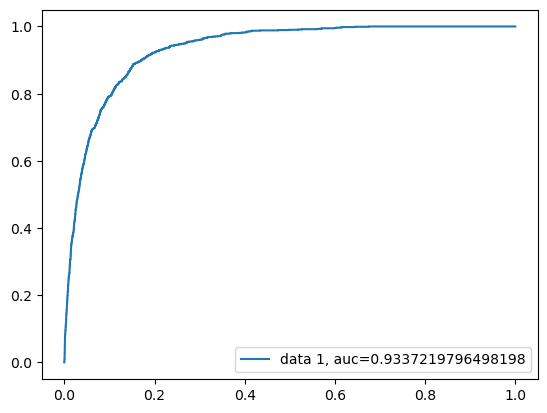

In [25]:
from sklearn import metrics

y_pred_proba = model.predict_proba(X_test)[::,1]

fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr, tpr, label="data 1, auc="+str(auc))

plt.legend(loc=4)

plt.show()

In [26]:
df_copy = df.dropna(subset=['customer_id', 'receipt_created'])

df_2022 = df_copy[df_copy['receipt_created'].dt.year.eq(2022)]

df_2023 = df_copy[df_copy['receipt_created'].dt.year.eq(2023)]

# Step 1: Get the set of unique customer IDs present in 2022
uniqueID = set(df_copy[df_copy['receipt_created'].dt.year.eq(2023)]['customer_id'])

# Step 2: Create a new column 'churn' and initialize it with False
df_copy['not_churn'] = False

# Step 3: Update 'churn' column based on existence in 2022 and 2023
df_copy.loc[df_copy['customer_id'].isin(uniqueID) , 'not_churn'] = True

df_copy.head()

/tmp/ipykernel_406/1125636267.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['not_churn'] = False


,receipt_row_id,employee_id,price,amount,vat,discount,row_type,campaign_id,campaign_discount,receipt_id,...,finished,wait_estimate,membership_condensated,is_member,becomes_member_later,waiting_time_minutes,cumulative_visits,cumulative_waiting_time_sum,cumulative_average_waiting_time,not_churn
110669,5907482,2,23.0,1,24.0,0,NaN,NaN,NaN,4734914,...,NaT,NaT,nonmember,False,False,NaN,1.0,NaN,NaN,False
147298,5948335,2,23.0,1,24.0,0,NaN,NaN,NaN,4765783,...,NaT,NaT,nonmember,False,False,NaN,2.0,NaN,NaN,False
10945,5805157,876339,33.0,1,24.0,0,NaN,NaN,NaN,4661931,...,2022-01-13 11:36:20,NaT,nonmember,False,True,2.333333,1.0,2.333333,2.333333,True
46591,5841705,843754,33.0,1,24.0,0,NaN,NaN,NaN,4687656,...,2022-02-10 12:41:18,NaT,nonmember,False,True,33.000000,2.0,35.333333,17.666667,True
46594,5841708,843754,12.5,1,24.0,0,NaN,NaN,NaN,4687656,...,2022-02-10 12:41:18,NaT,nonmember,False,True,33.000000,3.0,68.333333,22.777778,True


In [38]:
# Group by 'customer_id' and aggregate
churn = df_copy.groupby('customer_id').agg(
    not_churn=('not_churn', 'last'),
).reset_index()

customer_stats = df_2022.groupby('customer_id').agg(
    most_recent_visit=('finished', 'max'),
).reset_index()

customer_stats['most_recent_visit'] = pd.to_datetime(customer_stats['most_recent_visit'])

# Create a reference datetime object for December 31, 2022
reference_date = pd.Timestamp('2022-12-31')

# Calculate the time since the last visit
customer_stats['time_since_last_visit'] = (reference_date - customer_stats['most_recent_visit']).dt.days

# Assuming customer_stats and churn_data are your DataFrames
merged_data = customer_stats.merge(churn[['customer_id', 'not_churn']], on='customer_id', how='left')

merged_data.head()

,customer_id,most_recent_visit,time_since_last_visit,not_churn
0,2.0,NaT,NaN,False
1,37.0,2022-12-20 17:17:29,10.0,True
2,39.0,2022-12-20 12:40:28,10.0,True
3,48.0,2022-12-22 17:09:08,8.0,True
4,72.0,2022-11-07 16:35:05,53.0,True


In [39]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer

# Sample DataFrame based on your data structure
data = merged_data

# Handle missing values in 'average_waiting_time'
imputer = SimpleImputer(strategy='mean')
data['time_since_last_visit'] = imputer.fit_transform(data[['time_since_last_visit']])

# Prepare the features and target variable
X = data[['time_since_last_visit']]
y = data['not_churn'].astype(int)  # Convert boolean target variable to integer (0 or 1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.69      0.51      0.58      4828
           1       0.78      0.89      0.83      9606

    accuracy                           0.76     14434
   macro avg       0.74      0.70      0.71     14434
weighted avg       0.75      0.76      0.75     14434



Text(0.5, 1.0, 'Accuracy of Logistic refression: 0.758902591104337')

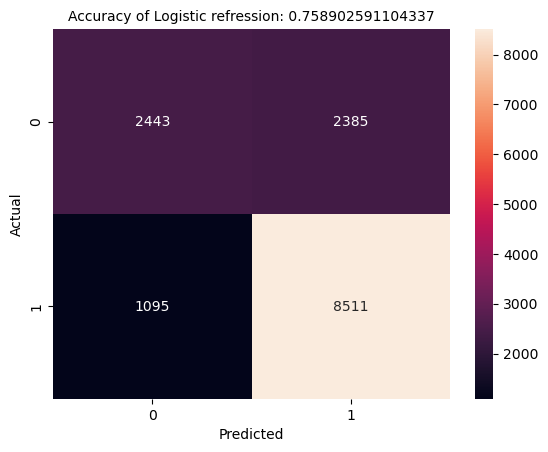

In [48]:
import seaborn as sns
from sklearn.metrics import accuracy_score

confusion_matrix = pd.crosstab(y_test, y_pred, rownames = ['Actual'], colnames = ['Predicted'])
sns.heatmap(confusion_matrix, annot = True, fmt = ".0f")
acc_score = accuracy_score(y_test, y_pred)
all_sample_title = 'Accuracy of Logistic refression: {0}'.format(acc_score)
plt.title(all_sample_title, size = 10)

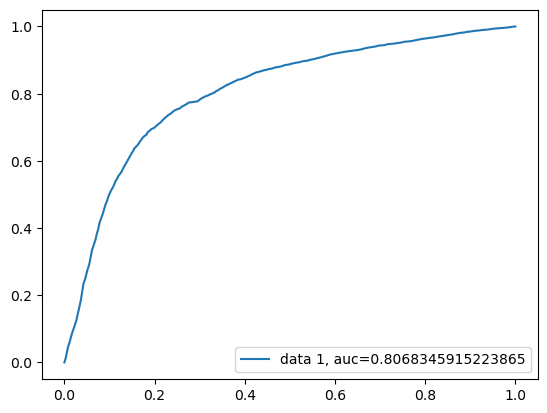

In [40]:
from sklearn import metrics

y_pred_proba = model.predict_proba(X_test)[::,1]

fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr, tpr, label="data 1, auc="+str(auc))

plt.legend(loc=4)

plt.show()

/tmp/ipykernel_406/1461339152.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_rate_by_group = df.groupby('time_since_last_visit_group')['churn'].mean().reset_index()


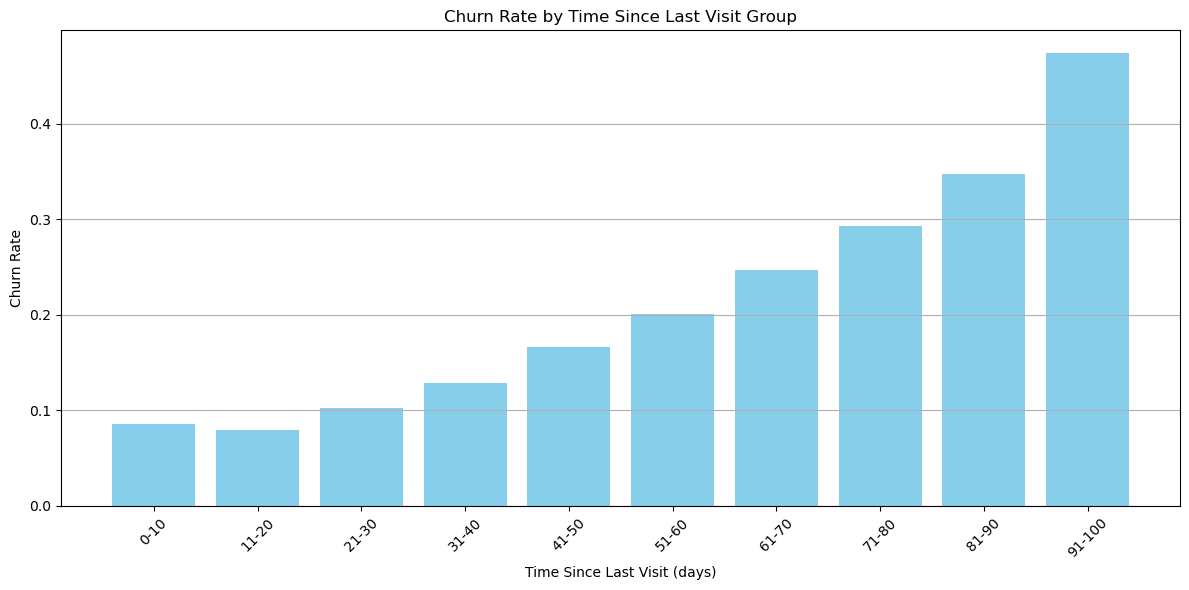

In [49]:
df = data.copy()

# Define bins for 'time_since_last_visit'
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
bin_labels = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100']

# Categorize 'time_since_last_visit' into bins
df['time_since_last_visit_group'] = pd.cut(df['time_since_last_visit'], bins=bins, labels=bin_labels, right=False)

# Convert 'not_churn' to integer (True=1, False=0) if necessary
df['churn'] = (~df['not_churn']).astype(int)

# Group by 'time_since_last_visit_group' and calculate churn rate
churn_rate_by_group = df.groupby('time_since_last_visit_group')['churn'].mean().reset_index()

# Plot the churn rate by grouped time intervals
plt.figure(figsize=(12, 6))
plt.bar(churn_rate_by_group['time_since_last_visit_group'], churn_rate_by_group['churn'], color='skyblue')
plt.title('Churn Rate by Time Since Last Visit Group')
plt.xlabel('Time Since Last Visit (days)')
plt.ylabel('Churn Rate')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [55]:
df=pd.read_csv('hackathon_data.csv', dtype={25:str})

In [59]:
start_date = pd.to_datetime('2022-01-04')
end_date = pd.to_datetime('2022-12-31')

df['receipt_created'] = pd.to_datetime(df['receipt_created'])

transaction_date = np.random.choice(pd.date_range(start_date, end_date), size=1)[0]

# Calculate the start date of the last 3 months period
three_months_ago = transaction_date - pd.DateOffset(months=3)

recent_transactions = df[df['receipt_created'] > three_months_ago]
recent_transactions = df[df['receipt_created'] < transaction_date]

transactions_per_customer = recent_transactions.groupby('customer_id').size()
transactions_per_customer.head()

/tmp/ipykernel_406/3330812479.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['receipt_created'] = pd.to_datetime(df['receipt_created'])


DateParseError: Unknown datetime string format, unable to parse: 2.1.2022 12.30.04, at position 0

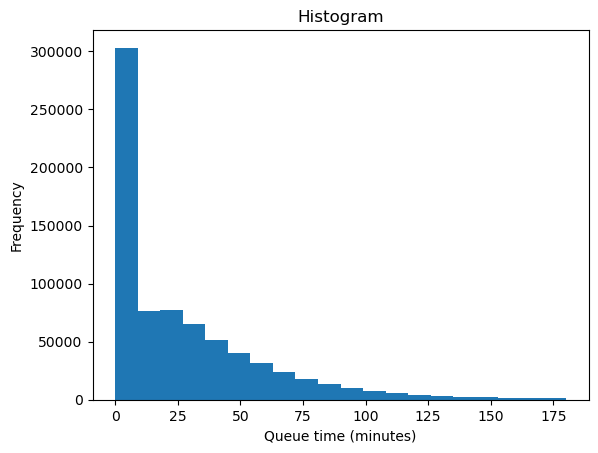

count    741386.000000
mean         27.065956
std          31.961275
min           0.000000
25%           0.850000
50%          16.966667
75%          41.683333
max         179.983333
Name: queue_time, dtype: float64

In [51]:
# Wait time before service

import matplotlib.pyplot as plt
import datetime as dt

df_receipt['queue_time'] = (df_receipt['serviced']-df_receipt['added']).dt.total_seconds()/60
# Assumption: negative wait times should be interpreted as zero
df_receipt['queue_time'] = df_receipt['queue_time'].where(df_receipt['queue_time']>0, 0)
# Assumption: wait times should be less than three hours
df_receipt['queue_time'] = df_receipt['queue_time'].where(df_receipt['queue_time']<60*3, np.nan)

plt.hist(df_receipt['queue_time'], bins=20)
plt.xlabel('Queue time (minutes)')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()

df_receipt['queue_time'].describe()

In [17]:
# Calculate wait time by membership tier
df_receipt.groupby("membership_condensated").aggregate({"queue_time" : ['mean','count']})

queue_time        
                             mean   count
membership_condensated                   
gold                    30.514513   15723
nonmember               26.429883  576795
platinum                26.688758    1650
silver                  29.197601  147178
white                   15.907083      40

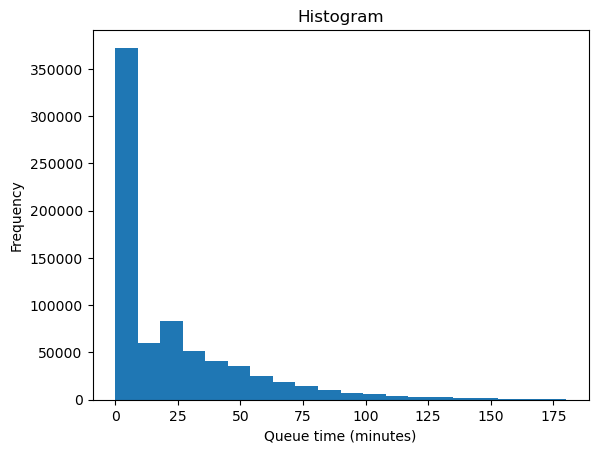

count    742737.000000
mean         21.712343
std          29.915485
min           0.000000
25%           0.000000
50%           8.816667
75%          34.000000
max         179.983333
Name: expected_queue_time, dtype: float64
Correlation between expected and true wait time: 


0.8523149173393986

In [18]:
# Expected wait time before service

df_receipt['expected_queue_time'] = (df_receipt['wait_estimate']-df_receipt['added']).dt.total_seconds()/60

# Assumption: negative wait times should be interpreted as zero
df_receipt['expected_queue_time'] = df_receipt['expected_queue_time'].where(df_receipt['expected_queue_time']>0, 0)
# Assumption: wait times should be less than three hours
df_receipt['expected_queue_time'] = df_receipt['expected_queue_time'].where(df_receipt['expected_queue_time']<60*3, np.nan)

plt.hist(df_receipt['expected_queue_time'], bins=20)
plt.xlabel('Queue time (minutes)')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()

print(df_receipt['expected_queue_time'].describe())
print("Correlation between expected and true wait time: ")
df_receipt['expected_queue_time'].corr(df_receipt['queue_time'])


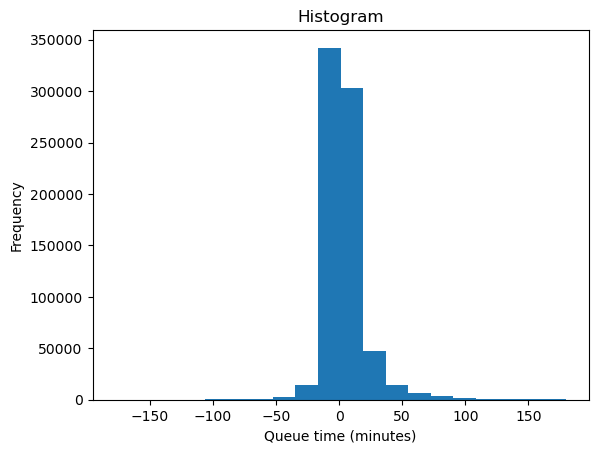

count    740725.000000
mean          5.509085
std          16.765213
min        -177.616667
25%           0.050000
50%           1.216667
75%           7.633333
max         179.783333
Name: wait_time_overtime, dtype: float64

In [19]:
# How much do customers wait more than expected

df_receipt['wait_time_overtime'] = df_receipt['queue_time']-df_receipt['expected_queue_time']

plt.hist(df_receipt['wait_time_overtime'], bins=20)
plt.xlabel('Queue time (minutes)')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()

df_receipt['wait_time_overtime'].describe()

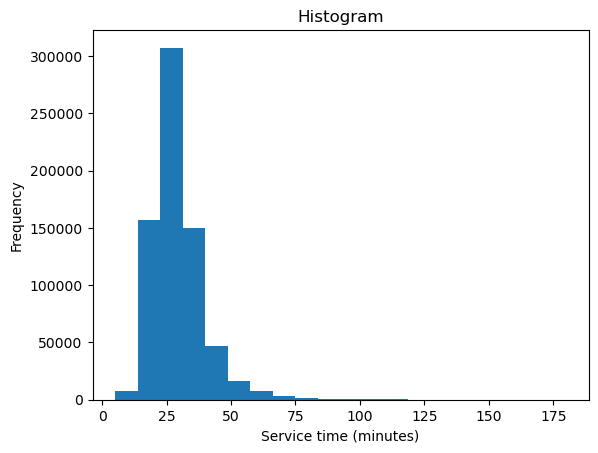

count    701386.000000
mean         29.410710
std          10.761208
min           5.016667
25%          22.816667
50%          27.483333
75%          33.433333
max         179.916667
Name: service_time, dtype: float64

In [20]:
# Calculate service times

df_receipt['service_time'] = (df_receipt['finished']-df_receipt['serviced']).dt.total_seconds()/60
# Assumption: over three hours service time is not realistic and can thus be excluded
df_receipt['service_time'] = df_receipt['service_time'].where(df_receipt['service_time']<60*3, np.nan)
# Assumption: under five minutes service time is not realistic and can thus be excluded
df_receipt['service_time'] = df_receipt['service_time'].where(df_receipt['service_time']>5, np.nan)
# Assumption: doesn't make sense to calculate service times for non-service receipts
df_receipt['service_time'] = df_receipt['service_time'].where(df_receipt['product_category_Service']>0, np.nan)

plt.hist(df_receipt['service_time'], bins=20)
plt.xlabel('Service time (minutes)')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()

df_receipt['service_time'].describe()

In [21]:
# Calculate service time by membership tier
print(df_receipt.groupby("membership_condensated").aggregate({"service_time" : ['mean','count']}))

                       service_time        
                               mean   count
membership_condensated                     
gold                      35.518786   15214
nonmember                 29.849775  542198
platinum                  42.708195    1507
silver                    26.946898  142428
white                     26.533333      39


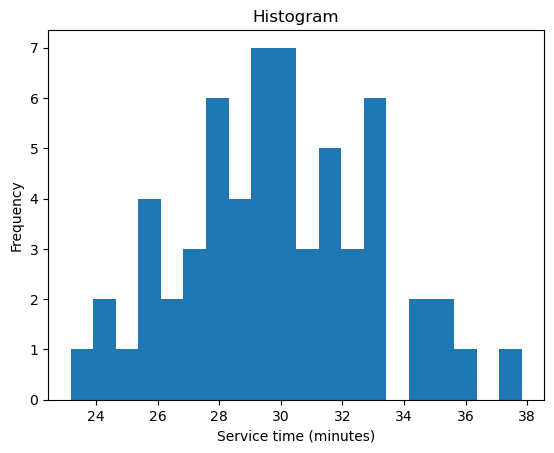

,pob_id,service_time_mean,service_time_count
count,67.000000,60.000000,67.000000
mean,52.582090,29.856471,10468.447761
std,28.593891,3.067650,5676.057019
min,2.000000,23.176549,0.000000
25%,29.500000,27.832142,7226.000000
50%,52.000000,29.816654,11752.000000
75%,77.500000,31.889371,14578.500000
max,99.000000,37.818330,22496.000000


In [22]:
# Service time by store

pob_data = df_receipt.groupby("pob_id").agg(
    service_time_mean=('service_time', 'mean'), 
    service_time_count=('service_time', 'count'),
    ).copy().reset_index()
# Assumption: only include stores with more than 1000 observations
pob_data['service_time_mean'] = pob_data['service_time_mean'].where(pob_data['service_time_count']>1000, np.nan)
plt.hist(pob_data['service_time_mean'], bins=20)
plt.xlabel('Service time (minutes)')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()

pob_data.describe()

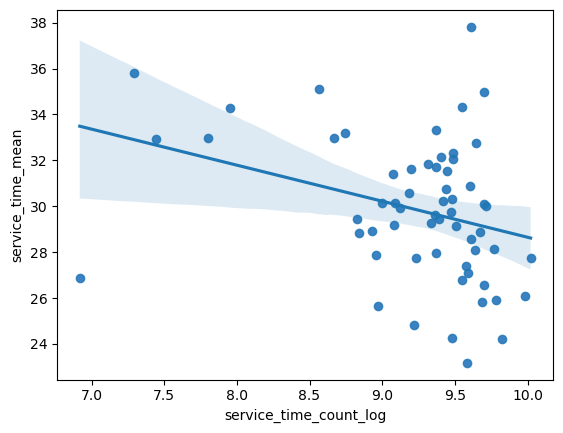

In [23]:
# Relationship between total store service volume and average service time

import seaborn as sns

pob_data['service_time_count_log'] = pob_data['service_time_count']
pob_data['service_time_count_log'] = pob_data['service_time_count_log'].where(pob_data['service_time_count_log']>0, np.nan)
pob_data['service_time_count_log'] = np.log(pob_data['service_time_count_log'])

# Create a scatter plot of the 'sea' and 'sales' columns
ax = sns.scatterplot(x='service_time_count_log', y='service_time_mean', data=pob_data, color='blue', alpha=.3)

# Add a line plot showing the regression line
ax = sns.regplot(x='service_time_count_log', y='service_time_mean', data=pob_data)
ax.set_xlabel("service_time_count_log")
ax.set_ylabel("service_time_mean")
plt.show()

In [24]:
df_receipt.columns

Index(['receipt_id', 'receipt_row_id', 'row_value', 'row_value_product',
       'customer_id', 'product_category_Membership', 'product_category_Other',
       'product_category_Product', 'product_category_Service',
       'membership_condensated', 'membership_id', 'receipt_created', 'added',
       'serviced', 'finished', 'wait_estimate', 'product_name', 'pob_id',
       'queue_time', 'expected_queue_time', 'wait_time_overtime',
       'service_time'],
      dtype='object')

In [25]:
# Calculate service interval by membership tier

df_services = df_receipt.loc[df_receipt['product_category_Service']>0].sort_values(by=['customer_id', 'receipt_created']).copy()
df_services['service_interval'] = df_services.groupby('customer_id')['receipt_created'].diff().dt.total_seconds()/(60*60*24)
print(df_services['service_interval'].describe())
df_services.groupby("membership_condensated").aggregate({"service_interval" : ['mean','median','count']})

count    535053.000000
mean         54.706303
std          55.581538
min           0.000000
25%          26.959618
50%          38.065683
75%          60.989340
max         721.104329
Name: service_interval, dtype: float64


service_interval                   
                                   mean     median   count
membership_condensated                                    
gold                          25.525755  22.034595   14865
nonmember                     64.973154  47.003657  379619
platinum                      25.178891  20.947830    1572
silver                        30.119975  27.922708  138979
white                         36.799259  32.958692      18

In [26]:
df_receipt.head()

,receipt_id,receipt_row_id,row_value,row_value_product,customer_id,product_category_Membership,product_category_Other,product_category_Product,product_category_Service,membership_condensated,...,added,serviced,finished,wait_estimate,product_name,pob_id,queue_time,expected_queue_time,wait_time_overtime,service_time
0,4653670,1,33.0,0.0,NaN,0,0,0,1,nonmember,...,2022-01-02 12:00:27,2022-01-02 12:00:29,2022-01-02 12:29:54,NaT,[M Cut™],27,0.033333,0.0,0.033333,29.416667
1,4653671,1,33.0,0.0,NaN,0,0,0,1,nonmember,...,2022-01-02 12:22:26,2022-01-02 12:22:28,2022-01-02 12:43:54,NaT,[M Cut™],27,0.033333,0.0,0.033333,21.433333
2,4653672,1,33.0,0.0,NaN,0,0,0,1,nonmember,...,2022-01-02 12:23:44,2022-01-02 12:31:25,2022-01-02 12:53:51,NaT,[M Cut™],27,7.683333,0.0,7.683333,22.433333
3,4653673,1,33.0,0.0,747701.0,0,0,0,1,nonmember,...,2022-01-02 13:10:08,2022-01-02 13:10:10,2022-01-02 13:37:49,NaT,[M Cut™],27,0.033333,0.0,0.033333,27.650000
4,4653674,1,33.0,0.0,755200.0,0,0,0,1,nonmember,...,2022-01-02 13:23:49,2022-01-02 13:23:52,2022-01-02 13:40:00,NaT,[M Cut™],27,0.050000,0.0,0.050000,16.133333


Percentage of customers buying something during service: 
0.1375480388898511
                          buying        
                            mean   count
membership_condensated                  
gold                    0.134267   31214
nonmember               0.142409  607565
platinum                0.097292    3361
silver                  0.124767  212332
white                   0.090909      44
                       product_purchase_sum       
                                     median  count
membership_condensated                            
gold                                   22.0   4191
nonmember                              24.0  86523
platinum                               21.0    327
silver                                 23.0  26492
white                                  30.0      4


<Axes: xlabel='product_purchase_sum', ylabel='Density'>

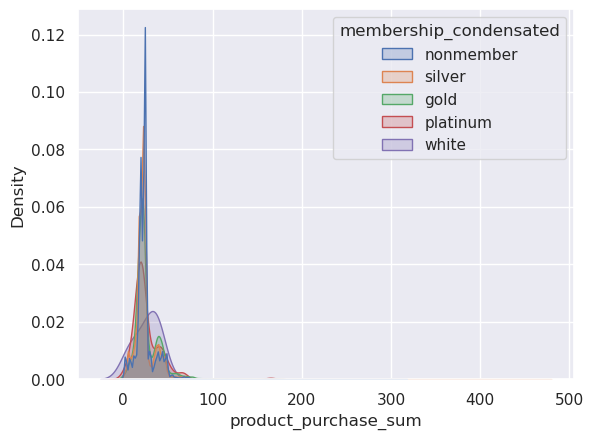

In [27]:
# Calculate product purchase converstions
# (% of service customers buying something)

# Notice we use a different aggregation level here

df['product_price']=df['price']*(df['product_category']=='Product')*1*df['amount']
df['product_purchase_sum'] = df.groupby('receipt_id')['product_price'].transform('sum')
df_services = df.loc[df['product_category']=='Service'].sort_values(by=['customer_id', 'receipt_created'])
df_services['service_interval'] = df_services.groupby('customer_id')['receipt_created'].diff().dt.total_seconds()/(60*60*24)
df=df.drop(['product_price','product_purchase_sum'],axis=1)

print("Percentage of customers buying something during service: ")
df_services['buying'] = (df_services['product_purchase_sum']>0)*1
print(df_services['product_purchase_sum'].loc[df_services['product_purchase_sum']>0].count()/len(df_services))

print(df_services.groupby("membership_condensated").aggregate({"buying" : ['mean','count']}))

# Calculate value of purchases when buying something

mask = df_services['product_purchase_sum']>0
print(df_services[mask].groupby("membership_condensated").aggregate({"product_purchase_sum" : ['median','count']}))

purchases_when_something = df_services['product_purchase_sum'].loc[df_services['product_purchase_sum']>0]

purchases_when_something.describe()

# Visualize the density distributions
sns.set_theme()
sns.kdeplot(
    data=df_services[mask], 
    x="product_purchase_sum", 
    hue="membership_condensated", 
    fill=True,
    common_norm=False
    )

In [28]:
# Aggregate the data to customer-month-level

df_monthly = df_receipt.groupby(['customer_id', pd.Grouper(key='receipt_created', freq='M')]).agg(
    {'receipt_row_id': 'count', # Note that after aggregation this actually captures just the number of rows that were aggregated
     'row_value': 'sum', # Total value of the receipt
     'row_value_product': 'sum', # Total value of the receipt from product sales
     'product_category_Membership': 'sum',
     'product_category_Other': 'sum',
     'product_category_Product': 'sum',
     'product_category_Service': 'sum',
     'membership_condensated': 'last',
     'membership_id': 'last',
     'added':'last',
     'serviced':'last',
     'finished':'last',
     'wait_estimate':'last',
     'product_name': list, # A list of lists, with each list the names of products that were purchased
     'pob_id': 'last',
     }).reset_index()

# Examine the data
df_monthly.head(10)

,customer_id,receipt_created,receipt_row_id,row_value,row_value_product,product_category_Membership,product_category_Other,product_category_Product,product_category_Service,membership_condensated,membership_id,added,serviced,finished,wait_estimate,product_name,pob_id
0,2.0,2022-03-31,1,23.0,0.0,0,0,0,1,nonmember,NaN,NaT,NaT,NaT,NaT,[[M Buzz Cut™]],70
1,2.0,2022-04-30,1,23.0,0.0,0,0,0,1,nonmember,NaN,NaT,NaT,NaT,NaT,[[M Buzz Cut™]],70
2,37.0,2022-01-31,1,33.0,0.0,0,0,0,1,nonmember,NaN,2022-01-13 11:11:43,2022-01-13 11:14:03,2022-01-13 11:36:20,NaT,[[M Cut™]],77
3,37.0,2022-02-28,1,45.5,12.5,0,0,1,1,nonmember,NaN,2022-02-10 11:49:42,2022-02-10 12:22:42,2022-02-10 12:41:18,NaT,"[[M Cut™, Gold - Bespoke Matte Paste]]",90
4,37.0,2022-03-31,1,33.0,0.0,0,0,0,1,nonmember,NaN,2022-03-02 13:26:27,2022-03-02 13:59:06,2022-03-02 14:26:50,NaT,[[M Cut™]],90
5,37.0,2022-04-30,1,33.0,0.0,0,0,0,1,nonmember,NaN,2022-04-21 10:20:58,2022-04-21 10:45:47,2022-04-21 11:09:45,2022-04-21 10:41:00,[[M Cut™]],77
6,37.0,2022-05-31,1,58.0,24.0,0,0,1,1,nonmember,NaN,2022-05-18 12:40:08,2022-05-18 12:57:01,2022-05-18 13:19:32,2022-05-18 12:54:00,"[[M Cut™, Gold - Classic Shampoo 250ml]]",77
7,37.0,2022-06-30,1,34.0,0.0,0,0,0,1,nonmember,NaN,2022-06-13 10:15:22,2022-06-13 11:59:11,2022-06-13 12:20:13,2022-06-13 11:33:00,[[M Cut™]],77
8,37.0,2022-08-31,2,116.0,48.0,0,0,2,2,nonmember,NaN,2022-08-23 10:46:00,2022-08-23 11:06:32,2022-08-23 11:29:16,2022-08-23 11:01:00,"[[M Cut™, Gold - Stout Matte Paste], [M Cut™, ...",77
9,37.0,2022-09-30,1,34.0,0.0,0,0,0,1,nonmember,NaN,2022-09-22 11:27:39,2022-09-22 11:57:55,2022-09-22 12:16:47,2022-09-22 11:52:00,[[M Cut™]],37


        month  no_customers
0  2022-01-31         19410
1  2022-02-28         20795
2  2022-03-31         24207
3  2022-04-30         24143
4  2022-05-31         24556
5  2022-06-30         26523
6  2022-07-31         25405
7  2022-08-31         26504
8  2022-09-30         23678
9  2022-10-31         23663
10 2022-11-30         23196
11 2022-12-31         24746
12 2023-01-31         22955
13 2023-02-28         22134
14 2023-03-31         24323
15 2023-04-30         23947
16 2023-05-31         25121
17 2023-06-30         26079
18 2023-07-31         25243
19 2023-08-31         26575
20 2023-09-30         25112
21 2023-10-31         23626
22 2023-11-30         23718
23 2023-12-31         25069


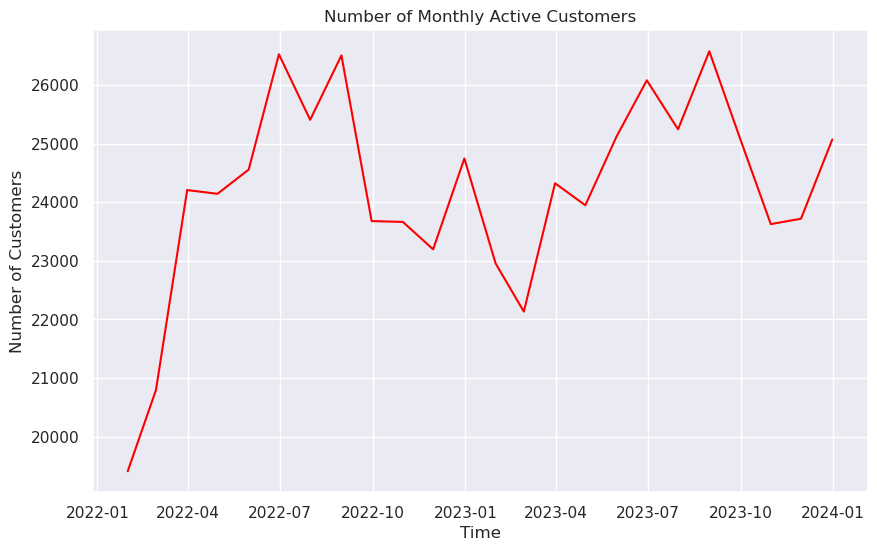

In [29]:
# Number of monthly active customers

customers_over_time = df_monthly.groupby('receipt_created').agg({'customer_id': 'nunique'}).reset_index().rename(columns={"receipt_created":"month","customer_id": "no_customers"})

print(customers_over_time)

customers_over_time = customers_over_time.sort_values('month')

plt.figure(figsize=(10, 6))
plt.plot(customers_over_time['month'],customers_over_time['no_customers'],color="red")
plt.xlabel('Time')
plt.ylabel('Number of Customers')
plt.title('Number of Monthly Active Customers')
plt.show()

In [30]:
# Calculate total, new and lost customers for each month
# Notice that the customers may actually come back in the following month(s)
# Because the data is already aggregated at the customer-month level
# the resulting column customer_id will contain a list of all customer_id's with transactions in month ending in 'receipt_created'

monthly_user_lists = df_monthly.groupby('receipt_created')['customer_id'].agg(list).reset_index()
monthly_user_lists['previous_id'] =  monthly_user_lists.shift(+1)['customer_id']
monthly_user_lists['new_id'] = None
monthly_user_lists['gone_id'] = None
for index, row in monthly_user_lists.iterrows():
    if row['previous_id'] is not None:
        new = sorted(list(set(row['customer_id'])-set(row['previous_id'])))
        monthly_user_lists.at[index, 'new_id'] = new
        gone = sorted(list(set(row['previous_id'])-set(row['customer_id'])))
        monthly_user_lists.at[index, 'gone_id'] = gone
    else:
        monthly_user_lists.at[index, 'new_id'] = []
        monthly_user_lists.at[index, 'gone_id'] = []

monthly_user_lists['total_customers'] = monthly_user_lists['customer_id'].apply(len)
monthly_user_lists['new_customers'] = monthly_user_lists['new_id'].apply(len)
monthly_user_lists['gone_customers'] = monthly_user_lists['gone_id'].apply(len)

print("---\nCustomer id lists:\n")
print(monthly_user_lists[['customer_id','previous_id','new_id','gone_id']].head())

---
Customer id lists:

                                         customer_id  \
0  [37.0, 39.0, 48.0, 90.0, 110.0, 114.0, 118.0, ...   
1  [37.0, 48.0, 90.0, 98.0, 110.0, 114.0, 118.0, ...   
2  [2.0, 37.0, 72.0, 90.0, 110.0, 114.0, 118.0, 1...   
3  [2.0, 37.0, 48.0, 90.0, 98.0, 110.0, 113.0, 11...   
4  [37.0, 39.0, 48.0, 73.0, 90.0, 98.0, 110.0, 11...   

                                         previous_id  \
0                                               None   
1  [37.0, 39.0, 48.0, 90.0, 110.0, 114.0, 118.0, ...   
2  [37.0, 48.0, 90.0, 98.0, 110.0, 114.0, 118.0, ...   
3  [2.0, 37.0, 72.0, 90.0, 110.0, 114.0, 118.0, 1...   
4  [2.0, 37.0, 48.0, 90.0, 98.0, 110.0, 113.0, 11...   

                                              new_id  \
0                                                 []   
1  [98.0, 135.0, 244.0, 245.0, 257.0, 267.0, 299....   
2  [2.0, 72.0, 134.0, 162.0, 183.0, 220.0, 237.0,...   
3  [48.0, 98.0, 113.0, 149.0, 221.0, 244.0, 257.0...   
4  [39.0, 73.0, 114.0,

In [31]:
print("---\nSummary of customers gained and gone:\n")
print(monthly_user_lists[['receipt_created','total_customers','new_customers','gone_customers']])

---
Summary of customers gained and gone:

   receipt_created  total_customers  new_customers  gone_customers
0       2022-01-31            19410              0               0
1       2022-02-28            20795          12345           10960
2       2022-03-31            24207          14232           10820
3       2022-04-30            24143          12572           12636
4       2022-05-31            24556          13049           12636
5       2022-06-30            26523          14405           12438
6       2022-07-31            25405          12783           13901
7       2022-08-31            26504          13957           12858
8       2022-09-30            23678          11367           14193
9       2022-10-31            23663          12419           12434
10      2022-11-30            23196          12094           12561
11      2022-12-31            24746          13137           11587
12      2023-01-31            22955          11429           13220
13      2023-02-28 

In [32]:
# Select a subset of data for analysis
# It can be convinent to get try out an idea for a smaller dataset first
# For illustrative purposes, pick new customers that started in march of 2022

df_first_month = df_monthly.groupby('customer_id')['receipt_created'].first().reset_index()
df_first_month.columns = ['customer_id', 'first_month']
df_monthly = pd.merge(df_monthly, df_first_month, on='customer_id', how='left')
df_cohort = df_monthly[df_monthly['first_month']=='2022-03-31']


In [33]:
# Checking that the data is generated properly
df_cohort.describe()

,customer_id,receipt_created,receipt_row_id,row_value,row_value_product,product_category_Membership,product_category_Other,product_category_Product,product_category_Service,membership_id,added,serviced,finished,wait_estimate,pob_id,first_month
count,52568.000000,52568,52568.000000,52568.000000,52568.000000,52568.000000,52568.000000,52568.000000,52568.000000,5384.000000,51972,51972,51972,42009,52568.000000,52568
mean,791409.445823,2022-12-24 06:36:34.186577408,1.040481,40.975627,3.612754,0.018129,0.001103,0.207103,1.183667,203848.354012,2022-12-11 14:26:39.721215488,2022-12-11 14:58:15.779573504,2022-12-11 15:32:07.057761792,2023-02-04 18:01:37.926158848,49.138716,2022-03-31 00:00:00.000000256
min,2.000000,2022-03-31 00:00:00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,36263.000000,2022-03-01 08:49:14,2022-03-01 09:00:28,2022-03-01 09:25:53,2022-03-29 09:01:00,2.000000,2022-03-31 00:00:00
25%,726190.000000,2022-06-30 00:00:00,1.000000,33.000000,0.000000,0.000000,0.000000,0.000000,1.000000,198953.750000,2022-06-07 13:37:30,2022-06-07 14:05:46.249999872,2022-06-07 14:29:08.500000,2022-08-25 10:20:00,28.000000,2022-03-31 00:00:00
50%,795171.000000,2022-11-30 00:00:00,1.000000,35.000000,0.000000,0.000000,0.000000,0.000000,1.000000,204191.000000,2022-11-24 11:14:19.500000,2022-11-24 11:23:22.500000,2022-11-24 11:47:21.500000,2023-01-31 14:01:00,45.000000,2022-03-31 00:00:00
75%,874395.500000,2023-06-30 00:00:00,1.000000,41.000000,0.000000,0.000000,0.000000,0.000000,1.000000,209252.250000,2023-06-06 16:01:29,2023-06-06 16:19:29.750000128,2023-06-06 16:49:48.750000128,2023-07-10 16:52:00,73.000000,2022-03-31 00:00:00
max,904838.000000,2023-12-31 00:00:00,11.000000,750.000000,100.000000,6.000000,1.000000,7.000000,36.000000,217972.000000,2023-12-31 14:43:32,2023-12-31 16:21:03,2024-01-02 15:15:45,2023-12-31 16:23:00,99.000000,2022-03-31 00:00:00
std,105775.981138,NaN,0.220588,36.818182,9.589759,0.140773,0.033198,0.518904,0.554584,8170.699939,NaN,NaN,NaN,NaN,25.910842,NaN


In [34]:
# Calculate quarterly active customers for the cohort
# This approximates churn but is not that exactly
# Customers may be in 'hiatus' between periods
df_cohort.loc[:,'year_quarter'] = pd.to_datetime(df_cohort['receipt_created']).dt.to_period('Q')

df_retention = df_cohort.groupby('year_quarter')['customer_id'].nunique()
df_retention/df_retention.max()

/tmp/ipykernel_229/2381929489.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cohort.loc[:,'year_quarter'] = pd.to_datetime(df_cohort['receipt_created']).dt.to_period('Q')


year_quarter
2022Q1    1.000000
2022Q2    0.568381
2022Q3    0.580258
2022Q4    0.522832
2023Q1    0.484202
2023Q2    0.470595
2023Q3    0.457680
2023Q4    0.419857
Freq: Q-DEC, Name: customer_id, dtype: float64

In [35]:
# Try another cohort

df_cohort = df_monthly[df_monthly['first_month']=='2022-06-30']
df_cohort.loc[:,'year_quarter'] = pd.to_datetime(df_cohort['receipt_created']).dt.to_period('Q')

df_retention = df_cohort.groupby('year_quarter')['customer_id'].nunique()
df_retention/df_retention.max()

/tmp/ipykernel_229/3392065695.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cohort.loc[:,'year_quarter'] = pd.to_datetime(df_cohort['receipt_created']).dt.to_period('Q')


year_quarter
2022Q2    1.000000
2022Q3    0.389303
2022Q4    0.379561
2023Q1    0.332919
2023Q2    0.338101
2023Q3    0.327529
2023Q4    0.290630
Freq: Q-DEC, Name: customer_id, dtype: float64

    pob_id receipt_created  cumulative_pob
12      25      2022-01-31             1.0
59      91      2022-01-31             2.0
5       13      2022-01-31             3.0
6       14      2022-01-31             4.0
39      64      2022-01-31             5.0
..     ...             ...             ...
64      98      2023-10-31            62.0
49      78      2023-11-30            63.0
60      92      2023-11-30            64.0
65      99      2023-11-30            65.0
36      59      2023-12-31            66.0

[66 rows x 3 columns]


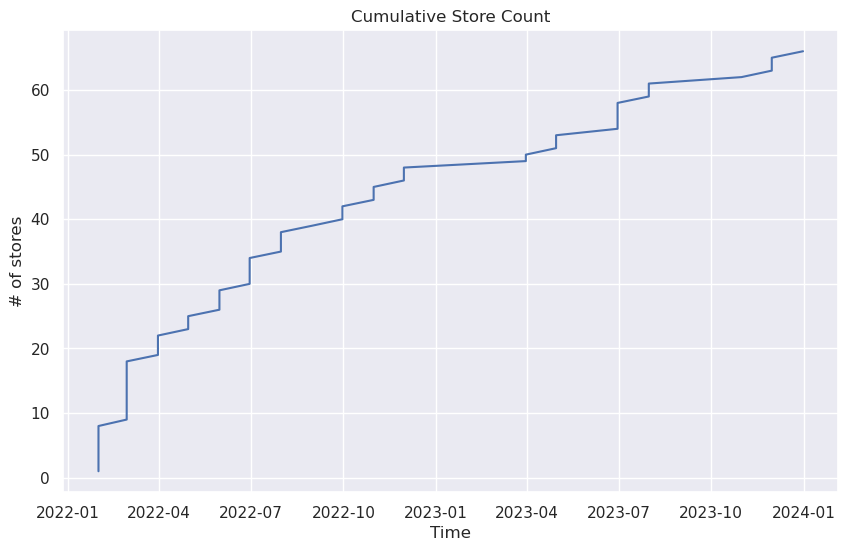

,pob_id,receipt_created,cumulative_pob
12,25,2022-01-31,1.0
59,91,2022-01-31,2.0
5,13,2022-01-31,3.0
6,14,2022-01-31,4.0
39,64,2022-01-31,5.0
...,...,...,...
64,98,2023-10-31,62.0
49,78,2023-11-30,63.0
60,92,2023-11-30,64.0
65,99,2023-11-30,65.0


In [36]:
# We can also analyze the growth of the store portfolio
# Possible closures are not accounted for
df_first_month_pob = df_monthly.groupby('pob_id')['receipt_created'].first().reset_index()
df_first_month_pob=df_first_month_pob.sort_values('receipt_created')
df_first_month_pob['cumulative_pob']=df_first_month_pob['pob_id'].expanding().count()
print(df_first_month_pob)
plt.figure(figsize=(10,6))
plt.plot(df_first_month_pob['receipt_created'], df_first_month_pob['cumulative_pob'])
plt.xlabel('Time')
plt.ylabel('# of stores')
plt.title('Cumulative Store Count')
plt.grid(True)
plt.show()
df_first_month_pob